In [1]:
import argparse
from os.path import dirname
import torch
import torchvision
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

# from utils.models import Classifier

import torch.nn as nn
from os.path import join, dirname, isfile
import torch.nn.functional as F
from torchvision.models.resnet import resnet34

from torch.utils.tensorboard import SummaryWriter
from utils.loader import Loader
from utils.loss import cross_entropy_loss_and_accuracy
from utils.dataset import NCaltech101
from torch.utils.data.dataloader import default_collate


In [2]:
torch.manual_seed(777)
np.random.seed(777)

In [3]:
validation_dataset="/ws/data/N-Caltech101/validation/"
training_dataset="/ws/data/N-Caltech101/training/"
log_dir="/ws/external/log/log_trilinear/temp"
device="cuda:0"
num_workers=4
pin_memory=True
batch_size=4
num_epochs=2
save_every_n_epochs=2
checkpoint = "/ws/external/log/log_trilinear/model_best.pth"
# "/ws/external/log_1.4_b4/model_best.pth" # model_best.pth checkpoint_13625_0.5990.pth
    
assert os.path.isdir(dirname(log_dir)), f"Log directory root {dirname(log_dir)} not found."
assert os.path.isdir(validation_dataset), f"Validation dataset directory {validation_dataset} not found."
assert os.path.isdir(training_dataset), f"Training dataset directory {training_dataset} not found."

print(f"----------------------------\n"
      f"Starting training with \n"
      f"num_epochs: {num_epochs}\n"
      f"batch_size: {batch_size}\n"
      f"device: {device}\n"
      f"log_dir: {log_dir}\n"
      f"training_dataset: {training_dataset}\n"
      f"validation_dataset: {validation_dataset}\n"
      f"----------------------------")




----------------------------
Starting training with 
num_epochs: 2
batch_size: 4
device: cuda:0
log_dir: /ws/external/log/log_trilinear/temp
training_dataset: /ws/data/N-Caltech101/training/
validation_dataset: /ws/data/N-Caltech101/validation/
----------------------------


In [4]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation
    

In [5]:
class Loader:
    def __init__(self, dataset, batch_size=2, num_workers=2, pin_memory=True, device="cuda:0"):
        self.device = device
        split_indices = list(range(len(dataset)))
        sampler = torch.utils.data.sampler.SubsetRandomSampler(split_indices)
        self.loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                             num_workers=num_workers, pin_memory=pin_memory,
                                             collate_fn=collate_events)

    def __iter__(self):
        for data in self.loader:
            data = [d.to(self.device) for d in data]
            yield data

    def __len__(self):
        return len(self.loader)

def collate_events(data):
    labels = []
    events = []
    for i, d in enumerate(data):
        labels.append(d[1])
        ev = np.concatenate([d[0], i*np.ones((len(d[0]),1), dtype=np.float32)],1)
        events.append(ev)
    events = torch.from_numpy(np.concatenate(events,0))
    labels = default_collate(labels)
    return events, labels

In [6]:
# datasets, add augmentation to training set
training_dataset = NCaltech101(training_dataset, augmentation=True)
validation_dataset = NCaltech101(validation_dataset)

# construct loader, handles data streaming to gpu
training_loader = Loader(training_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, device="cuda:0")
validation_loader = Loader(validation_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, device="cuda:0")

In [7]:
class ValueLayer(nn.Module):
    def __init__(self, mlp_layers, activation=nn.ReLU(), num_channels=9):
        assert mlp_layers[-1] == 1, "Last layer of the mlp must have 1 input channel."
        assert mlp_layers[0] == 1, "First layer of the mlp must have 1 output channel"

        nn.Module.__init__(self)
        self.mlp = nn.ModuleList()
        self.activation = activation

        # create mlp
        in_channels = 1
        for out_channels in mlp_layers[1:]:
            self.mlp.append(nn.Linear(in_channels, out_channels))
            in_channels = out_channels

        # init with trilinear kernel
#         path = join(dirname(__file__), "quantization_layer_init", "trilinear_init.pth")
        path = join("/ws/external/utils/quantization_layer_init", "trilinear_init.pth")

        if isfile(path):
            state_dict = torch.load(path)
            self.load_state_dict(state_dict)
        else:
            self.init_kernel(num_channels)

    def forward(self, x):
        # create sample of batchsize 1 and input channels 1
#         print("x: ", x.grad_fn)
        x = x[None,...,None]

        # apply mlp convolution
        for i in range(len(self.mlp[:-1])):
            x = self.activation(self.mlp[i](x))
#         print("value forward: ", x.grad_fn)
        x = self.mlp[-1](x)
        x = x.squeeze()

        return x

    def init_kernel(self, num_channels):
        ts = torch.zeros((1, 2000))
        optim = torch.optim.Adam(self.parameters(), lr=1e-2)

        torch.manual_seed(1)

        for _ in tqdm.tqdm(range(1000)):  # converges in a reasonable time
            optim.zero_grad()

            ts.uniform_(-1, 1)

            # gt
            gt_values = self.trilinear_kernel(ts, num_channels)

            # pred
            values = self.forward(ts)

            # optimize
            loss = (values - gt_values).pow(2).sum()

            loss.backward()
            optim.step()


    def trilinear_kernel(self, ts, num_channels):
        gt_values = torch.zeros_like(ts)

        gt_values[ts > 0] = (1 - (num_channels-1) * ts)[ts > 0]
        gt_values[ts < 0] = ((num_channels-1) * ts + 1)[ts < 0]

        gt_values[ts < -1.0 / (num_channels-1)] = 0
        gt_values[ts > 1.0 / (num_channels-1)] = 0

        return gt_values

class TrilinearLayer(nn.Module):
    def __init__(self, num_channels=9):
        nn.Module.__init__(self)
        self.num_channels = num_channels

    def forward(self, x):
        # create sample of batchsize 1 and input channels 1
        x = x[None,...,None]

        # apply trilineaer kernel
        x = self.trilinear_kernel(x, self.num_channels)
        x = x.squeeze()

        return x

    def trilinear_kernel(self, ts, num_channels):
        gt_values = torch.zeros_like(ts)

        gt_values[ts > 0] = (1 - (num_channels-1) * ts)[ts > 0]
        gt_values[ts < 0] = ((num_channels-1) * ts + 1)[ts < 0]

        if num_channels == 1:
            gt_values[ts < -1.0] = 0
            gt_values[ts > 1.0] = 0
        else:
            gt_values[ts < -1.0 / (num_channels-1)] = 0
            gt_values[ts > 1.0 / (num_channels-1)] = 0

        return gt_values

In [8]:
class QuantizationLayer(nn.Module):
    def __init__(self, dim,
                 mlp_layers=[1, 100, 100, 1],
                 activation=nn.LeakyReLU(negative_slope=0.1)):
        nn.Module.__init__(self)
#         self.value_layer = ValueLayer(mlp_layers,
#                                       activation=activation,
#                                       num_channels=dim[0])
        self.value_layer = TrilinearLayer()
        self.dim = dim

    def forward(self, events):
        # points is a list, since events can have any size
        B = int((1+events[-1,-1]).item())
        num_voxels = int(2 * np.prod(self.dim) * B)
        vox = events[0].new_full([num_voxels,], fill_value=0)
        C, H, W = self.dim

        # get values for each channel
        x, y, t, p, b = events.t()

#         # normalizing timestamps
#         for bi in range(B):
#             t[events[:,-1] == bi] /= t[events[:,-1] == bi].max()

        p = (p+1)/2  # maps polarity to 0, 1

        idx_before_bins = x \
                          + W * y \
                          + 0 \
                          + W * H * C * p \
                          + W * H * C * 2 * b
        
#         k = self.value_layer.forward(t)
#         print("t: ", t.grad_fn)
#         print("k: ", k.grad_fn)

        for i_bin in range(C):
            values = t * self.value_layer.forward(t-i_bin/(C-1))

            # draw in voxel grid
            idx = idx_before_bins + W * H * i_bin
            vox.put_(idx.long(), values, accumulate=True)

        vox = vox.view(-1, 2, C, H, W)
        vox = torch.cat([vox[:, 0, ...], vox[:, 1, ...]], 1)

        return vox





In [27]:
class Classifier(nn.Module):
    def __init__(self,
                 voxel_dimension=(9,180,240),  # dimension of voxel will be C x 2 x H x W
                 crop_dimension=(224, 224),  # dimension of crop before it goes into classifier
                 num_classes=101,
                 mlp_layers=[1, 30, 30, 1],
                 activation=nn.LeakyReLU(negative_slope=0.1),
                 pretrained=True,
                 adv=False,
                 epsilon=4):

        nn.Module.__init__(self)
        self.quantization_layer = QuantizationLayer(voxel_dimension, mlp_layers, activation)
        self.classifier = resnet34(pretrained=pretrained)

        self.crop_dimension = crop_dimension
        self.num_classes = num_classes
        self.adv = adv
        self.epsilon = epsilon 
        # replace fc layer and first convolutional layer
        input_channels = 2*voxel_dimension[0]
        self.voxel_dimension = voxel_dimension
        self.classifier.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.classifier.fc = nn.Linear(self.classifier.fc.in_features, num_classes)

    def crop_and_resize_to_resolution(self, x, output_resolution=(224, 224)):
        B, C, H, W = x.shape
        if H > W:
            h = H // 2
            x = x[:, :, h - W // 2:h + W // 2, :]
        else:
            h = W // 2
            x = x[:, :, :, h - H // 2:h + H // 2]

        x = F.interpolate(x, size=output_resolution)

        return x

#     def forward(self, x, labels=None):

#         training = self.training

#         if training:
#             vox = self.quantization_layer.forward(x)
#             vox_cropped = self.crop_and_resize_to_resolution(vox, self.crop_dimension)
#             if self.adv == True:
#                 self.classifier.eval()
#                 adv, target_label = self.pgd_attack(vox_cropped, labels)
#                 vox_cropped = torch.cat((vox_cropped, adv), dim=0)
#                 labels = torch.cat((labels, labels), dim=0)
#                 self.classifier.train()
#                 pred = self.classifier.forward(adv)
#                 return pred, vox
#             else:
#                 pred = self.classifier.forward(vox_cropped)
#                 return pred, vox
#         else:
#             if self.adv == True:
#                 vox = self.quantization_layer.forward(x)
#                 vox_cropped = self.crop_and_resize_to_resolution(vox, self.crop_dimension)
#                 adv, target_label = self.pgd_attack(vox_cropped, labels)
#                 pred = self.classifier.forward(adv)
#                 return pred, vox, adv, target_label
#             else:
#                 vox = self.quantization_layer.forward(x)
#                 vox_cropped = self.crop_and_resize_to_resolution(vox, self.crop_dimension)
#                 pred = self.classifier.forward(vox_cropped)
#                 return pred, vox

    def forward(self, x):
#         print("vox prev: ", x.grad_fn)
        vox = self.quantization_layer.forward(x)
#         print("vox: ", vox.grad_fn)
        vox_cropped = self.crop_and_resize_to_resolution(vox, self.crop_dimension)
#         print("vox_cropped: ", vox_cropped.grad_fn)
        pred = self.classifier.forward(vox_cropped)
#         print("pred: ", pred.grad_fn)
#         return pred, vox
        return pred, vox_cropped

    def pgd_attack(self, image_clean, label, num_iter=2, step_size=0.1, epsilon=4, original=False):
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted

        adv = image_clean.clone().detach()
        adv.requires_grad = True
        for i in range(num_iter):
            pred = self.classifier.forward(adv)
            losses, accuracy = cross_entropy_loss_and_accuracy(pred, target_label)
            g = torch.autograd.grad(losses, adv,
                                    retain_graph=False, create_graph=False)[0]
            
            g_topk = self.get_topk(g, epsilon)
            g_topk = self.apply_polarity_constraint(g_topk)
            
            # Linf step
            if original:
                adv = adv + torch.sign(g_topk) * step_size  # untargeted
            else:
                adv = adv - torch.sign(g_topk) * step_size  # targeted

            # Linf project for time??
        
        pred = self.classifier.forward(adv)
        
        
        return adv, target_label, pred, g
    
    
    def pgd_event_attack(self, event_clean, label, num_iter=2, step_size=0.5, epsilon=4, original=False):
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted
        
#         self.fill_null_event(event_clean, 1, self.voxel_dimension)
        
        
        adv = event_clean.clone().detach()
        adv = self.fill_null_event(adv, T=epsilon, H=180, W=240)

        adv.requires_grad = True
        for i in range(num_iter):
            vox_adv = self.quantization_layer.forward(adv)
#             print("vox: ", vox_adv.grad_fn)
            vox_cropped_adv = self.crop_and_resize_to_resolution(vox_adv, self.crop_dimension)
#             print("vox_cropped: ", vox_cropped_adv.grad_fn)
            pred = self.classifier.forward(vox_cropped_adv)
            losses, accuracy = cross_entropy_loss_and_accuracy(pred, target_label)
            g = torch.autograd.grad(losses, adv,
                                    retain_graph=False, create_graph=False)[0]
            
#             g_topk = self.get_topk(g, epsilon)
#             g_topk = self.apply_polarity_constraint(g_topk)
            g_topk = g
            
            # Linf step
            if original:
                adv = adv + torch.sign(g_topk) * step_size  # untargeted
            else:
                adv = adv - torch.sign(g_topk) * step_size  # targeted

            # Linf project for time??
        vox_adv = self.quantization_layer.forward(adv)
        vox_cropped_adv = self.crop_and_resize_to_resolution(vox_adv, self.crop_dimension)
        pred = self.classifier.forward(vox_cropped_adv)
        
        
        return vox_cropped_adv, target_label, pred, g, adv
    
    def pgd_event_attack2(self, event_clean, label, num_iter=2, event_step_size=0.5, time_step_size=0.5, epsilon=4, original=False):
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted
        
        
        adv = event_clean.clone().detach()
        adv = self.fill_null_event(adv, T=epsilon, H=180, W=240)
        
        # event adv should be 0 or 1
        event_adv = (adv[:,2]!=0).float()
        event_adv.requires_grad=True
        
        # if adv==0: 0 < time < 1 random uniform
        time_adv = torch.where(adv[:,2]==0, torch.rand_like(adv[:,2]), adv[:, 2])
        time_adv.requires_grad = True
        
        for i in range(num_iter):
            event_adv.requires_grad = True
            time_adv.requires_grad = True
            adv[:, 2] = event_adv * time_adv
            vox_adv = self.quantization_layer.forward(adv)
            vox_cropped_adv = self.crop_and_resize_to_resolution(vox_adv, self.crop_dimension)
            pred = self.classifier.forward(vox_cropped_adv)
            losses, accuracy = cross_entropy_loss_and_accuracy(pred, target_label)
            event_g = torch.autograd.grad(losses, event_adv,
                                    retain_graph=True, create_graph=False)[0]
            time_g = torch.autograd.grad(losses, time_adv,
                                    retain_graph=False, create_graph=False)[0]
            
            # Linf step
            if original:
                event_adv = event_adv + torch.sign(event_g) * event_step_size  # untargeted
                time_adv = time_adv + torch.sign(time_g) * time_step_size  # untargeted

            else:
                event_adv = event_adv - torch.sign(event_g) * event_step_size  # targeted
                time_adv = time_adv - torch.sign(time_g) * time_step_size  # targeted
                
            # Linf project
            event_adv = torch.where(event_adv < 0.5, torch.zeros_like(event_adv), torch.ones_like(event_adv)).float().detach()
            time_adv = torch.clamp(time_adv, min=0.0, max=1.0)
            adv[:, 2] = event_adv * time_adv
            event_adv = event_adv.detach()
            time_adv = time_adv.detach()
            
        vox_adv = self.quantization_layer.forward(adv)
        vox_cropped_adv = self.crop_and_resize_to_resolution(vox_adv, self.crop_dimension)
        pred = self.classifier.forward(vox_cropped_adv)
        
        
        return vox_cropped_adv, target_label, pred, g
#         return adv, event_adv, time_adv
    
    
    def random_attack(self, image_clean, label, num_iter=2, step_size=0.1, epsilon=4, original=False):
        if original:
            target_label = label    # untargeted
        else:
            target_label = self._create_random_target(label)    # targeted

        adv = image_clean.clone().detach()
        adv.requires_grad = True
        for i in range(num_iter):
            pred = self.classifier.forward(adv)
            losses, accuracy = cross_entropy_loss_and_accuracy(pred, target_label)
            g = torch.autograd.grad(losses, adv,
                                    retain_graph=False, create_graph=False)[0]
            
            g_randk = self.get_randk(g, epsilon)
            g_randk = self.apply_polarity_constraint(g_randk)
            # Linf step
            if original:
                adv = adv + torch.sign(g_randk) * step_size  # untargeted
            else:
                adv = adv - torch.sign(g_randk) * step_size  # targeted

            # Linf project for time??
        
        pred = self.classifier.forward(adv)
        
        return adv, target_label, pred, g
    

    def _create_random_target(self, label):
        label_offset = torch.randint_like(label, low=0, high=self.num_classes)
        return (label + label_offset) % self.num_classes
    
    def get_topk(self, x, n=4):
        B, C, H, W = x.size()
        x = torch.reshape(x, (B, C, H*W))
#         topk = torch.zeros(B, C, H*W)
        topk = torch.zeros_like(x)
        vals, idx, = torch.topk(torch.abs(x), n)
        for i in range(B):
            for j in range(C): 
                for k in idx[i, j]:
                    topk[i, j, k] = x[i, j, k]
        topk = torch.reshape(topk, (B, C, H, W))
        return topk
    
    def get_event_topk(self, x, n=4):
        B, C, H, W = x.size()
        x = torch.reshape(x, (B, C, H*W))
#         topk = torch.zeros(B, C, H*W)
        topk = torch.zeros_like(x)
        vals, idx, = torch.topk(torch.abs(x), n)
        for i in range(B):
            for j in range(C): 
                for k in idx[i, j]:
                    topk[i, j, k] = x[i, j, k]
        topk = torch.reshape(topk, (B, C, H, W))
        return topk
    
    def fill_null_event(self, events, T, H, W):
        B = int((1 + events[-1, -1]).item())
        vox = torch.zeros((W, H, T, 2, B))
        null_event = (vox == 0).nonzero().float().cuda()
        null_event[:, 2] = 0
#         events = torch.cat([events, null_event], dim=0)
        events = torch.cat([null_event, events], dim=0)
        return events
        
        
        
    def fill_null_event2(self, events, T, H, W):
        print("events shape: ", events.size())
        x, y, t, p, b = events.t()
        # points is a list, since events can have any size
        B = int((1+events[-1,-1]).item())
        num_voxels = int(2 * np.prod(T*H*W) * B)
        vox = events[0].new_full([num_voxels,], fill_value=0)

        # get values for each channel
        x, y, t, p, b = events.t()

        # normalizing timestamps
#         for bi in range(B):
#             t[events[:,-1] == bi] /= t[events[:,-1] == bi].max()
        
        
        p = (p+1)/2  # maps polarity to 0, 1

        idx_before_bins = x \
                          + W * y \
                          + 0 \
                          + W * H * T * p \
                          + W * H * T * 2 * b
       
#         values = t 
#         idx = idx_before_bins
#         vox.put_(idx.long(), values, accumulate=True)
#         vox = vox.view(-1, 2, T, H, W)
#         vox = torch.cat([vox[:, 0, ...], vox[:, 1, ...]], 1)
#         return vox

        if T == 1:
            values = t
            idx = idx_before_bins
            vox.put_(idx.long(), values, accumulate=True)
        else:
            for i_bin in range(T):
                values = t * self.value_layer.forward(t-i_bin/(T-1))

                # draw in voxel grid
                idx = idx_before_bins + W * H * i_bin
                vox.put_(idx.long(), values, accumulate=True)
        
        
        vox = vox.view(-1, 2, T, H, W)
        vox = torch.cat([vox[:, 0, ...], vox[:, 1, ...]], 1)
        
        return vox
        
    
    def get_randk(self, x, n=4):
        B, C, H, W = x.size()
        x = torch.reshape(x, (B, C, H*W))
#         topk = torch.zeros(B, C, H*W)
        topk = torch.zeros_like(x)
        vals, idx, = torch.topk(x, n)
        for i in range(B):
            for j in range(C): 
                for k in idx[i, j]:
                    l = torch.randint(low=0, high=H*W-1, size=(1,))
                    topk[i, j, l] = x[i, j, l]
        topk = torch.reshape(topk, (B, C, H, W))
        return topk
    
    def apply_polarity_constraint(self, x):
        B, C, H, W = x.size()
        p = x[:,:C//2,:,:]
        n = x[:,C//2:,:,:]
        p = torch.where(torch.abs(p)==torch.abs(n),  torch.zeros_like(p),p)
        x = torch.cat((p, n), dim=1)
        
        return x

In [28]:
# model, and put to device
model = Classifier(pretrained=False)
ckpt = torch.load(checkpoint)
model.load_state_dict(ckpt["state_dict"])
model = model.to(device)

# # optimizer and lr scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

writer = SummaryWriter(log_dir)

iteration = 0
min_validation_loss = 1000

In [29]:
_, (events, labels) = next(enumerate(validation_loader))
# optimizer.zero_grad()
pred, representation = model(events)


In [30]:
loss, accuracy = cross_entropy_loss_and_accuracy(pred, labels)

In [31]:
labels

tensor([39, 14, 49, 74], device='cuda:0')

In [32]:
pred.argmax(dim=1)

tensor([71, 14, 49, 74], device='cuda:0')

In [33]:
# adv, target_label, pred_adv, g = model.pgd_attack(representation, labels, num_iter=2, step_size=1, epsilon=10)
# pred_adv.argmax(dim=1)

In [34]:
adv, target_label, pred_adv, g, adv_event = model.pgd_event_attack(events, labels, num_iter=2, step_size=0.1, epsilon=2)
pred_adv.argmax(dim=1)

tensor([74,  4, 49, 12], device='cuda:0')

In [43]:
target_label

tensor([ 3,  4, 11, 62], device='cuda:0')

In [55]:
# adv, event_adv, time_adv = model.pgd_event_attack2(events, labels, num_iter=2, step_size=0.1, epsilon=2)
adv2, target_label2, pred_adv2, g2 = model.pgd_event_attack2(events, labels, num_iter=2, event_step_size=0.5, time_step_size=0.1, epsilon=2)
pred_adv2.argmax(dim=1)
# pred_adv.argmax(dim=1)

tensor([74, 14, 58, 41], device='cuda:0')

In [56]:
target_label2

tensor([73, 35, 58, 20], device='cuda:0')

In [57]:
# randadv, target_rand_label, pred_random, g = model.random_attack(representation, labels, num_iter=2, step_size=1, epsilon=10)
# pred_random.argmax(dim=1)

In [58]:
# target_rand_label

In [59]:
def create_image2(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()
    
    return representation

In [60]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

def show_image_row(xlist, ylist=None, fontsize=12, size=(2.5, 2.5), tlist=None, filename=None):
    H, W = len(xlist), len(xlist[0])
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    for w in range(W):
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)                
            ax.imshow(xlist[h][w].permute(1, 2, 0))
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            if ylist and w == 0: 
                ax.set_ylabel(ylist[h], fontsize=fontsize)
            if tlist:
                ax.set_title(tlist[h][w], fontsize=fontsize)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

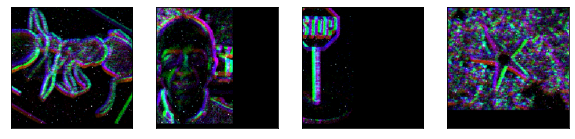

In [61]:
representation_vizualization2 = create_image2(representation)
show_image_row([representation_vizualization2.cpu()])

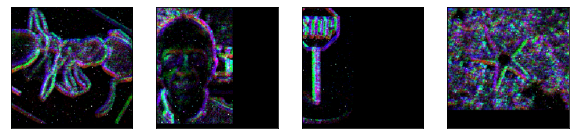

In [62]:
representation_adv = create_image2(adv)
show_image_row([representation_adv.detach().cpu()])


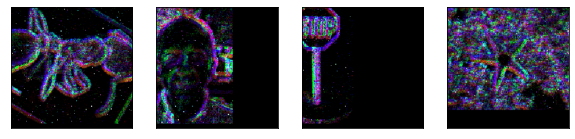

In [63]:
representation_adv2 = create_image2(adv2)
show_image_row([representation_adv2.detach().cpu()])

In [64]:
representation_randadv = create_image2(randadv)
show_image_row([representation_randadv.cpu()])

NameError: name 'randadv' is not defined

In [365]:
k = torch.tensor([0.0, 1.0, 2.1, 0.7, 0.4])
l = torch.where(k < 0.5, torch.tensor(0), torch.tensor(1)).float()

In [366]:
l.dtype

torch.float32

In [31]:
np.shape(representation_vizualization)

torch.Size([3, 184, 970])

In [78]:
import torch
import torch.nn.functional as F

src = torch.arange(25, dtype=torch.float).reshape(1, 1, 5, 5).requires_grad_()  # 1 x 1 x 5 x 5 with 0 ... 25
indices = torch.tensor([[-1, -1], [0, 0]], dtype=torch.float).reshape(1, 1, -1, 2)  # 1 x 1 x 2 x 2
output = F.grid_sample(src, indices)
print(output)  # tensor([[[[  0.,  12.]]]])

tensor([[[[ 0., 12.]]]], grad_fn=<GridSampler2DBackward>)


In [79]:
src

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]], requires_grad=True)

In [80]:
indices

tensor([[[[-1., -1.],
          [ 0.,  0.]]]])

In [81]:
output

tensor([[[[ 0., 12.]]]], grad_fn=<GridSampler2DBackward>)